# Bioimage Model Zoo Core  Example notebook

This notebook shows how to interact with the `bioimageio.core` programmatically to explore, load, use, and export content from the [BioImage Model Zoo](https://bioimage.io).

For a local use of this notebook the minimum package requirements can be found in `bioimageio.core_usage_requirements.txt` located in the same folder as the notebook.

## 0. Activate human readable output error messages and load dependencies

### 0.1. If running on Google Colab, install necessary dependencies

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
     %pip install bioimageio.core==0.6.7 torch==2.3.1 onnxruntime==1.18.0

### 0.2.Enable pretty_validation_errors

This function displays validation errors in a human readable format.

In [2]:
from bioimageio.spec.pretty_validation_errors import (
    enable_pretty_validation_errors_in_ipynb,
)
enable_pretty_validation_errors_in_ipynb()

### 0.3. Load general dependencies

In [3]:
# Load general dependencies
from imageio.v2 import imread
from bioimageio.spec.utils import download
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

# Function to display input and prediction output images
def show_images(sample_tensor, prediction_tensor):
    input_array = sample_tensor.members['input0'].data
    
    # Check for the number of channels to enable display
    input_array = np.squeeze(input_array)
    if len(input_array.shape)>2:
        input_array = input_array[0]

    output_array = prediction_tensor.members['output0'].data
    
    # Check for the number of channels to enable display
    output_array = np.squeeze(output_array)
    if len(output_array.shape)>2:
        output_array = output_array[0]

    plt.figure()
    ax1 = plt.subplot(1,2,1)
    ax1.set_title("Input")
    ax1.axis('off')
    plt.imshow(input_array)
    ax2 = plt.subplot(1,2,2)
    ax2.set_title("Prediction")
    ax2.axis('off')
    plt.imshow(output_array)
    plt.show()
        
    

## 1. Load a model

### 1.1 Inspect available models in the Bioimage Model Zoo

Go to https://bioimage.io to browser available models

### 1.2 Load model from the BioImage Model Zoo

`bioimage.io` resources may be identified via their bioimage.io __ID__, e.g. "affable-shark" or the [__DOI__](https://doi.org/) of their [__Zenodo__](https://zenodo.org/) backup.

Both of these options may be version specific ("affable-shark/1" or a version specific [__Zenodo__](https://zenodo.org/) backup [__DOI__](https://doi.org/)).

Alternatively, any rdf.yaml source, single file or in a .zip, may be loaded by providing its __local path__ or __URL__.

In [4]:
BMZ_MODEL_ID = ""#"affable-shark"
BMZ_MODEL_DOI = "" #"10.5281/zenodo.6287342"
BMZ_MODEL_URL = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files/rdf.yaml"

`load_description` is a function of the `bioimageio.spec` package, but as it is a sub-package of `bioimageio.core` it can also be called from it by `bioimageio.core.load_description`.

To learn more about the functionalities of the `bioimageio.spec` package, see the [bioimageio.spec package example notebook](https://github.com/bioimage-io/spec-bioimage-io/blob/main/example/load_model_and_create_your_own.ipynb), also available as a [Google Colab](https://colab.research.google.com/github/bioimage-io/spec-bioimage-io/blob/main/example/load_model_and_create_your_own.ipynb) notebook.

In [5]:
from bioimageio.core import load_description

# Load the model description
# ------------------------------------------------------------------------------
if BMZ_MODEL_ID != "":
    model = load_description(BMZ_MODEL_ID)  
    print(f"\nThe model '{model.name}' with ID '{BMZ_MODEL_ID}' has been correctly loaded.")
elif BMZ_MODEL_DOI != "":
    model = load_description(BMZ_MODEL_DOI)  
    print(f"\nThe model '{model.name}' with DOI '{BMZ_MODEL_DOI}' has been correctly loaded.")
elif BMZ_MODEL_URL != "":
    model = load_description(BMZ_MODEL_URL)  
    print(f"\nThe model '{model.name}' with URL '{BMZ_MODEL_URL}' has been correctly loaded.")
else:
    print('\nPlease specify a model ID, DOI or URL')

if "draft" in BMZ_MODEL_ID or "draft" in BMZ_MODEL_DOI or "draft" in BMZ_MODEL_URL:
    print(f"\nThis is the DRAFT version of '{model.name}'. \nDraft versions have not been reviewed by the Bioimage Model Zoo Team and may contain harmful code. Run with caution.")

# To be added later:
# elif model.version != model.lastest_version:
#   print('\nThe loaded version of the model is: ' + model.version, 'but the latest version of the model is: ' + model.lastest_version)

# TODO: on the model loading success responses add version loaded



computing SHA256 of 2717bc821b53e7554f84f82d494f5019-zero_mean_unit_variance.ijm (result: 767f2c3a50e36365c30b9e46e57fcf82e606d337e8a48d4a2440dc512813d186): 100%|██████████| 1/1 [00:00<00:00, 1675.04it/s]
computing SHA256 of 0fc5a081dd022def1829f39f58b667b5-test_input_0.npy (result: c29bd6e16e3f7856217b407ba948222b1c2a0da41922a0f79297e25588614fe2): 100%|██████████| 3/3 [00:00<00:00, 5748.25it/s]
computing SHA256 of 512ac1bb6de19fba42ae180732aa2f74-sample_input_0.tif (result: a24b3c708b6ca6825494eb7c5a4d221335fb3eef5eb9d03f4108907cdaad2bf9): 100%|██████████| 1/1 [00:00<00:00, 2359.00it/s]
computing SHA256 of 6908a856d9b4bab0b2bacbceb17c9142-test_output_0.npy (result: 510181f38930e59e4fd8ecc03d6ea7c980eb6609759655f2d4a41fe36108d5f5): 100%|██████████| 5/5 [00:00<00:00, 7302.06it/s] 
computing SHA256 of 011c6c06668d71d113e21511f83b6586-sample_output_0.tif (result: e8f99aabe8405427f515eba23a49f58ba50302f57d1fdfd07026e1984f836c5e): 100%|██████████| 5/5 [00:00<00:00, 7319.90it/s] 
computing S


The model 'NucleiSegmentationBoundaryModel' with URL 'https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files/rdf.yaml' has been correctly loaded.

This is the DRAFT version of 'NucleiSegmentationBoundaryModel'. 
Draft versions have not been reviewed by the Bioimage Model Zoo Team and may contain harmful code. Run with caution.


### 1.3 Inspect the model metadata

Model metadata includes author names, affiliations, license, and documentation.

The model 'NucleiSegmentationBoundaryModel' has the following properties and metadata

 Description:
'Nucleus segmentation for fluorescence microscopy'

 The authors of the model are: 
[Author(affiliation='EMBL Heidelberg', email=None, orcid=None, name='Constantin Pape', github_user='constantinpape')]

 It is maintained by:
[Maintainer(affiliation=None, email=None, orcid=None, name='Constantin Pape', github_user='constantinpape')]
'\n License: '
'CC-BY-4.0'

 If you use this model, you are expected to cite it as: 
[CiteEntry(text='training library', doi='10.5281/zenodo.5108853', url=None),
 CiteEntry(text='architecture', doi='10.1007/978-3-319-24574-4_28', url=None),
 CiteEntry(text='segmentation algorithm', doi='10.1038/nmeth.4151', url=None),
 CiteEntry(text='data', doi=None, url='https://www.nature.com/articles/s41592-019-0612-7')]

 Further documentation can be found here: https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files/documentation.md

No ass

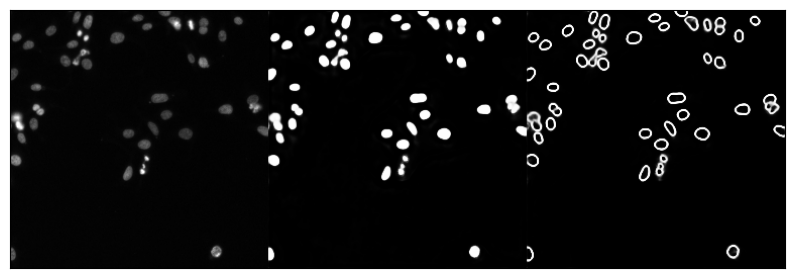

In [6]:
print(f"The model '{model.name}' has the following properties and metadata\n")
print(f" Description:") 
pprint(model.description)

print("\n The authors of the model are: ")
pprint(model.authors)

print("\n It is maintained by:")
pprint(model.maintainers)

pprint("\n License: ")
pprint(model.license)

print("\n If you use this model, you are expected to cite it as: ")
pprint(model.cite)

print(f"\n Further documentation can be found here: {model.documentation.absolute()}")

if model.git_repo == None:
    print(f"\nNo associated GitHub repository.")
else:
    print(f"\n GitHub repository: ")
    pprint(model.git_repo)

print(f"\n Covers of the model '{model.name}' are: ")
for cover in model.covers:
    cover_data = imread(download(cover).path)
    plt.figure(figsize=(10, 10))
    plt.imshow(cover_data)
    plt.xticks([])
    plt.yticks([])
    plt.show()


### 1.4 Get expected model inputs and outputs

Each model expects Inputs and returns Outputs with specific features. The following code shows how to get the full metadata of the expected inputs and outputs of the model.

In [7]:
print(f"Model '{model.name}' requires {len(model.inputs)} input(s) with the following features:")
for ipt in model.inputs:
    print(f"\ninput '{ipt.id}' with axes:")
    pprint(ipt.axes)
    print(f"Data description: {ipt.data}")
    print(f"Test tensor available at:  {ipt.test_tensor.source.absolute()}")
    if len(ipt.preprocessing) > 1:
        print("This input is preprocessed with: ")
        for p in ipt.preprocessing:
            print(p)

print("\n-------------------------------------------------------------------------------")
# # and what the model outputs are
print(f"Model '{model.name}' requires {len(model.outputs)} output(s) with the following features:")
for out in model.outputs:
    print(f"\noutput '{out.id}' with axes:")
    pprint(out.axes)
    print(f"Data description: {out.data}")
    print(f"Test tensor available at:  {out.test_tensor.source.absolute()}")
    if len(out.postprocessing) > 1:
        print("This output is postprocessed with: ")
        for p in out.postprocessing:
            print(p)

Model 'NucleiSegmentationBoundaryModel' requires 1 input(s) with the following features:

input 'input0' with axes:
[BatchAxis(id='batch', description='', type='batch', size=None),
 ChannelAxis(id='channel', description='', type='channel', channel_names=['channel0']),
 SpaceInputAxis(size=ParameterizedSize(min=64, step=16), id='y', description='', type='space', unit=None, scale=1.0, concatenable=False),
 SpaceInputAxis(size=ParameterizedSize(min=64, step=16), id='x', description='', type='space', unit=None, scale=1.0, concatenable=False)]
Data description: type='float32' range=(None, None) unit='arbitrary unit' scale=1.0 offset=None
Test tensor available at:  https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files/test_input_0.npy
This input is preprocessed with: 
id='ensure_dtype' kwargs=EnsureDtypeKwargs(dtype='float32')
id='zero_mean_unit_variance' kwargs=ZeroMeanUnitVarianceKwargs(axes=['channel', 'y', 'x'], eps=1e-06)
id='ensure_dtype' kwargs=EnsureDt

## 2. Test the model

The `bioimageio.core.test_model` function can be used to fully test the model.
This is done by running the predicition on the test input(s) and checking that they agree with the test output(s) provided in the model documentation.

This test should be run before using the model to ensure that it works properly.

----

`bioimageio.core.test_model` returns a validation dictionary with 'status'='passed'/'failed' and other detailed information that can be inspected by calling `.display()` on it.

The validation summary will indicate:
- the versions of the `bioimageio.spec` and `bioimageio.core` libraries used to run the validation
- the status of several validation steps
    - ✔️: Success
    - 🔍: information about the validation context
    - ⚠: Warning
    - ❌: Error

In [8]:
from bioimageio.core import test_model

test_summary = test_model(model)
test_summary.display()

2024-06-13 12:20:28.532 | INFO     | bioimageio.core._resource_tests:_test_model_inference:122 - starting 'Reproduce test outputs from test inputs'
2024-06-13 12:20:30.337 | INFO     | bioimageio.core._resource_tests:_test_model_inference_parametrized:192 - Testing inference with 4 different input tensor sizes



|        ✔️       |                                  bioimageio validation passed                                  |
|       ---       |                                              ---                                               |
| source          | https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files/rdf.yaml |
| format version  | model 0.5.3                                                                                    |
| bioimageio.spec | 0.5.3post2                                                                                     |
| bioimageio.core | 0.6.7                                                                                          |

|  ❓  |                     location                    |                                         detail                                        |
| --- |                       ---                       |                                          ---                                          |
| ✔️  |                                                 | initialized ModelDescr to describe model 0.5.3                                        |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | bioimageio.spec format validation model 0.5.3                                         |
| 🔍   | context.perform_io_checks                       | True                                                                                  |
| 🔍   | context.root                                    | https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files |
| 🔍   | context.known_files.zero_mean_unit_variance.ijm | 767f2c3a50e36365c30b9e46e57fcf82e606d337e8a48d4a2440dc512813d186                      |
| 🔍   | context.known_files.test_input_0.npy            | c29bd6e16e3f7856217b407ba948222b1c2a0da41922a0f79297e25588614fe2                      |
| 🔍   | context.known_files.sample_input_0.tif          | a24b3c708b6ca6825494eb7c5a4d221335fb3eef5eb9d03f4108907cdaad2bf9                      |
| 🔍   | context.known_files.test_output_0.npy           | 510181f38930e59e4fd8ecc03d6ea7c980eb6609759655f2d4a41fe36108d5f5                      |
| 🔍   | context.known_files.sample_output_0.tif         | e8f99aabe8405427f515eba23a49f58ba50302f57d1fdfd07026e1984f836c5e                      |
| 🔍   | context.known_files.weights.onnx                | df913b85947f5132bcdaf81d91af0963f60d44f4caf8a4fec672d96a2f327b44                      |
| 🔍   | context.known_files.unet.py                     | 7f5b15948e8e2c91f78dcff34fbf30af517073e91ba487f3edb982b948d099b3                      |
| 🔍   | context.known_files.environment.yaml            | e79043966078d1375f470dd4173eda70d1db66f70ceb568cf62a4fdc50d95c7f                      |
| 🔍   | context.known_files.weights.pt                  | 608f52cd7f5119f7a7b8272395b0c169714e8be34536eaf159820f72a1d6a5b7                      |
| 🔍   | context.known_files.weights-torchscript.pt      | 8410950508655a300793b389c815dc30b1334062fc1dadb1e15e55a93cbb99a0                      |
| 🔍   | context.warning_level                           | error                                                                                 |
| ⚠   | `documentation`                                 | No '# Validation' (sub)section found in documentation.md.                             |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | Has expected resource type                                                            |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | Reproduce test outputs from test inputs                                               |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | Run inference for inputs with batch_size: 2 and size parameter n: 0                   |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | Run inference for inputs with batch_size: 3 and size parameter n: 1                   |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | Run inference for inputs with batch_size: 1 and size parameter n: 2                   |
|     |                                                 |                                                                                       |
| ✔️  |                                                 | Run inference for inputs with batch_size: 2 and size parameter n: 3                   |
|     |                                                 |                                                                                       |


## 3. Running a prediction

`bioimageio.core` implements the functionality to run a prediction with models described in the `bioimage.io` format.

This includes functions to run predictions on `numpy.ndarray`/`xarray.DataArray` as input and convenience functions to run predictions for images stored on disc.

### 3.1. Load the test image and convert into a tensor

In [9]:
from bioimageio.spec.utils import load_array
from bioimageio.spec.model import v0_5

assert isinstance(model, v0_5.ModelDescr)
input_image = load_array(model.inputs[0].test_tensor)
print(f"array shape: {input_image.shape}")

array shape: (1, 1, 256, 256)


Create a `Tensor` (light wrapper around an `xarray.DataArray`) from the test input image. 

`bioimageio.core.Tensors/xarray.DataArrays` are like numpy arrays, but they have annotated axes.

The axes are used to validate that the axes of the input image match the axes expected by the model.

In [10]:
from bioimageio.core import Tensor

test_input_tensor = Tensor.from_numpy(input_image, dims=model.inputs[0].axes)

# print the axis annotations ('dims') and the shape of the input array
print(f"tensor shape: {test_input_tensor.tagged_shape}")

tensor shape: Frozen({'batch': 1, 'channel': 1, 'y': 256, 'x': 256})


A collection of tensors is called a `Sample`.

In the case of the `affable-shark` model it only has one input, but for models with multiple inputs a `Sample` includes a tensor for each input.

In [11]:
from bioimageio.core import Sample

sample = Sample(members={"raw": test_input_tensor}, stat=None, id="sample-from-numpy")

sample

Sample(members={'raw': <bioimageio.core.tensor.Tensor object at 0x147024410>}, stat=None, id='sample-from-numpy')

`bioimageio.core` provides the helper function `create_sample_for_model` to automatically create the `Sample` for the given model.

In [12]:
from bioimageio.core.digest_spec import create_sample_for_model
from bioimageio.spec.utils import download

input_paths = {ipt.id: download(ipt.test_tensor).path for ipt in model.inputs}
print(f"input paths: {input_paths}")
assert isinstance(model, v0_5.ModelDescr)
sample = create_sample_for_model(
    model=model, inputs=input_paths, sample_id="my_demo_sample"
)

sample

input paths: {'input0': PosixPath('/Users/marianaferreira/Library/Caches/bioimageio/0fc5a081dd022def1829f39f58b667b5-test_input_0.npy')}


Sample(members={'input0': <bioimageio.core.tensor.Tensor object at 0x16c0e7990>}, stat={}, id='my_demo_sample')

There is also  a helper function `get_test_inputs` to directly import the test input sample for a given model.

In [13]:
from bioimageio.core.digest_spec import get_test_inputs

test_sample = get_test_inputs(model)

test_sample

Sample(members={'input0': <bioimageio.core.tensor.Tensor object at 0x16de5b8d0>}, stat={}, id='test-input')

### 3.2. Create a prediciton pipeline

The `prediction_pipeline` function is used to run a prediction with a given model.

It applies the __pre-processing__, if indicated in the model rdf.yaml, runs __inference__ with the model and applies the __post-processing__, again if specified in the model rdf.yaml.

The `devices` argument can be used to specify which device(s), CPU, a single GPU, or multiple GPUs (not implemented yet), to use for inference with the model.

The default is `devices=None`, this will use a __GPU__ if available, otherwise it uses the __CPU__.


The `weight_format` argument can be used to specify which of the model's available weight formats to use.

The deafult is `weight_format=None`, this will use the weight format with highest priority (as defined by bioimageio.core).



In [14]:
from bioimageio.core import create_prediction_pipeline

devices = None
weight_format = None

prediction_pipeline = create_prediction_pipeline(
    model, devices=devices, weight_format=weight_format
)

Use the new prediction pipeline to run a prediction for the previously loaded test image.

The prediction pipeline returns a `Sample` object, which will be displayed via napari.

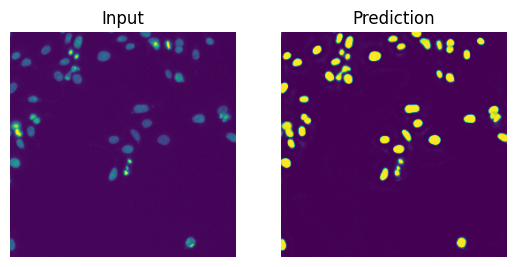

In [15]:
prediction: Sample = prediction_pipeline.predict_sample_without_blocking(sample)

# show the prediction result
show_images(sample, prediction)

### 3.3. Prediction without a PredicitionPipeline

`bioimageio.core` has two convenience functions `predict` and `predict_many` which allow the prediction of images without creating a `PredictionPipeline`.

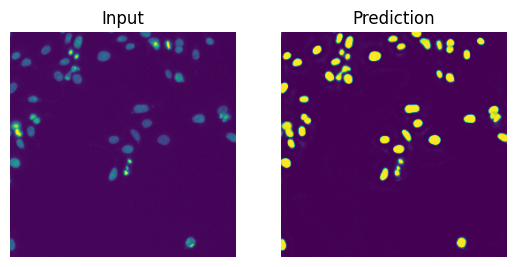

In [16]:
from bioimageio.core import predict  # , predict_many

# predict_many(model=model, inputs=[sample])

prediction: Sample = predict(model=model, inputs=sample)

# show the prediction result
show_images(sample, prediction)

### 3.3. Recover input and output tensors as numpy arrays

This example code shows how to recover the image information from the input and output tensors as numpy arrays.

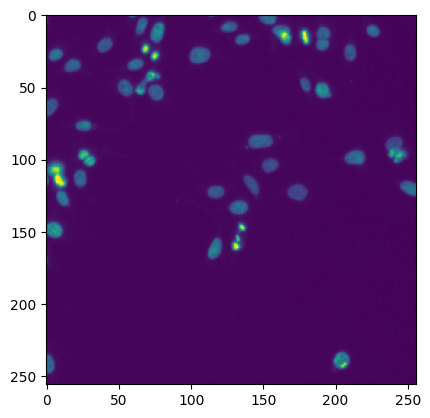

In [17]:
np_input_list = []
np_output_list = []

# iterate over the number of tensors inside the input sample
for ipt in range(len(sample.members.keys())):
    input_array = sample.members[f"input{ipt}"].data

    # Check for the number of channels to enable display
    input_array = np.squeeze(input_array)
    if len(input_array.shape)>2:
        input_array = input_array[0]
    
    np_input_list.append(input_array)


# iterate over the number of tensors inside the output prediction
for out in range(len(prediction.members.keys())):
    output_array = prediction.members[f"output{ipt}"].data

    # Check for the number of channels to enable display
    output_array = np.squeeze(output_array)
    if len(output_array.shape)>2:
        output_array = output_array[0]
    
    np_output_list.append(output_array)

plt.imshow(np_input_list[0])